In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot
import HomeMade as hm
import importlib
hm = importlib.reload(hm)

In [5]:
N = 1e6

all_features = ['eventCounter',
 'npv',
 'ntrk_pv0',
 'pv0_x',
 'pv0_y',
 'pv0_z',
 'a0xy',
 'a0',
 'a0z',
 'cosTheta',
 'v0_chi2',
 'v0_x',
 'v0_y',
 'v0_z',
 'v0_rxy',
 'v0_rxyErr',
 'v0_px',
 'v0_py',
 'v0_pz',
 'v0_pt',
 'v0_p',
 'v0_ptErr',
 'v0_ks_mass',
 'v0_la_mass',
 'v0_lb_mass',
 'v0_ks_massErr',
 'v0_la_massErr',
 'v0_lb_massErr',
 'v0_px1',
 'v0_py1',
 'v0_pz1',
 'v0_pt1',
 'v0_p1',
 'v0_px2',
 'v0_py2',
 'v0_pz2',
 'v0_pt2',
 'v0_p2',
 'v0_phi1',
 'v0_theta1',
 'v0_qOverP1',
 'v0_phi2',
 'v0_theta2',
 'v0_qOverP2',
 'alpha',
 'calpha',
 'epsilon1',
 'epsilon2',
 'Alpha',
 'pL1',
 'pL2',
 'pT',
 'thetastar',
 'rapidity_ks',
 'rapidity_la',
 'rapidity_lb',
 'pseudorapidity',]

path = "data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(all_features, entrystop = N)

path = "data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
file = uproot.open(path)
mc = file['tree'].pandas.df(all_features + ['trueKs'], entrystop = N)

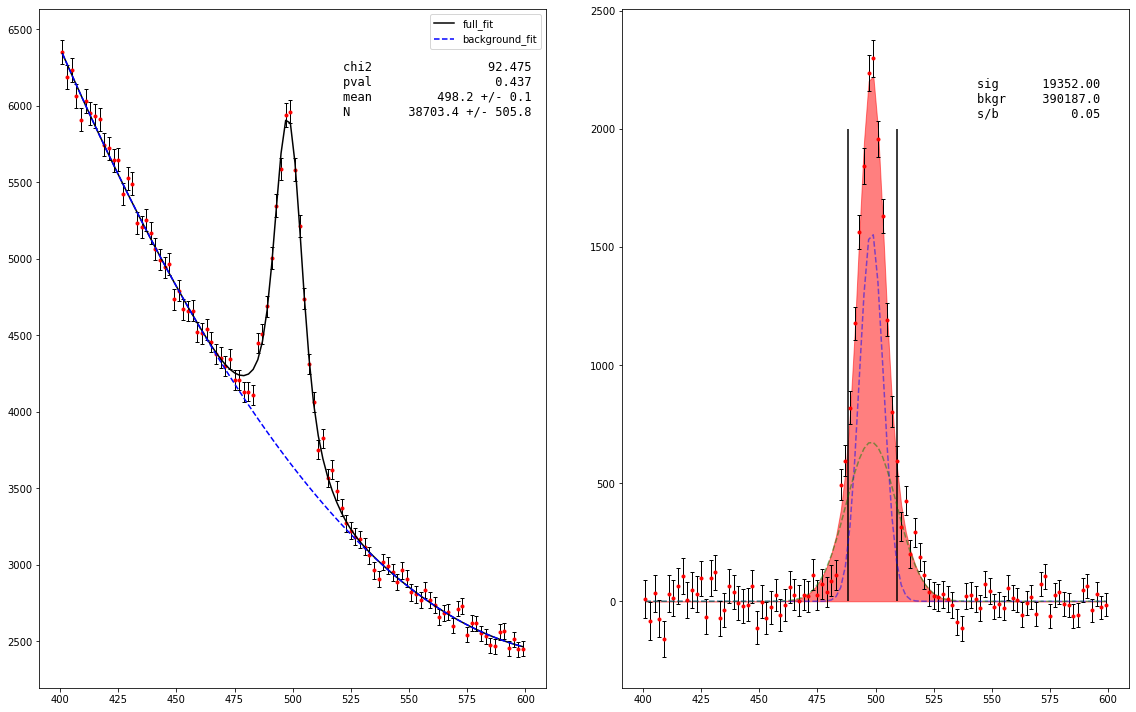

In [145]:
#Create pseudo background and signal from data
signal_range = (488,509)
side_band_l = (400,450)
side_band_r = (550,600)

def mask(array,lims):
    return (array>lims[0])&(array<lims[1])

vals, binedges = np.histogram(data.v0_ks_mass.loc[(data.v0_ks_mass>400)&(data.v0_ks_mass<600)],bins=100)
binc = 0.5*(binedges[:-1] + binedges[1:])

D = hm.fit_mass2(binc,vals,np.sqrt(vals))

# D['ax'][0].fill_between(binc[mask(binc,signal_range)],vals[mask(binc,signal_range)],min(vals))
D['ax'][1].vlines(signal_range,0,2000)

In [146]:
signal_range = (binedges[np.argmin(abs(binedges-signal_range[0]))],binedges[np.argmin(abs(binedges-signal_range[1]))])
side_band_r = (binedges[np.argmin(abs(binedges-side_band_r[0]))],binedges[np.argmin(abs(binedges-side_band_r[1]))])
side_band_l = (binedges[np.argmin(abs(binedges-side_band_l[0]))],binedges[np.argmin(abs(binedges-side_band_l[1]))])

In [160]:
N = int(D['sig_func'](binc[mask(binc,signal_range)]).sum()+D['bkgr_func'](binc[mask(binc,signal_range)]).sum())
N_bkgr = int(D['bkgr_func'](binc[mask(binc,signal_range)]).sum())
print("Sample Size;", N,"or",sum(mask(data.v0_ks_mass,signal_range)), "background size;", N_bkgr)
N = sum(mask(data.v0_ks_mass,signal_range)) - N_bkgr


Sample Size; 56441 or 56444 background size; 40330


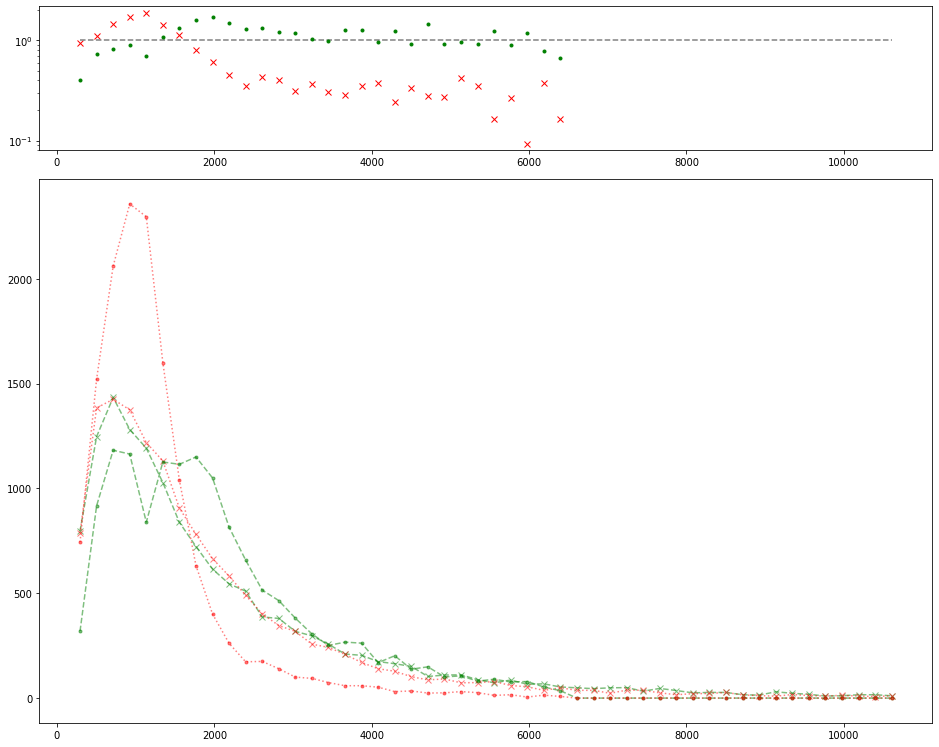

In [261]:
def hist(array,bins,bin_range):
    vals, binedges = np.histogram(array,bins=bins,range=bin_range)
    return vals, 0.5*(binedges[:-1]+binedges[1:])

def plot_distribution(mc, data, feature, bins = 100, particle_type = 'Ks'):
    fig, ax = plt.subplots(figsize=(16,10))
    q = (0.01,0.99)
    mc = mc[mask(mc[feature],np.quantile(mc[feature],q=q))]
    data = data[mask(data[feature],np.quantile(data[feature],q=q))]
    
    N = sum(mask(data.v0_ks_mass,signal_range)) - N_bkgr
    
    if isinstance(feature,str):
        feat_mc = mc[feature]
        feat_data = data[feature]
    elif isinstance(feature,dict):
        feat_mc = feature['mc']
        feat_data = feature['data']
    else:
        print("Error with 'feature'")
        return
    
    bin_range = (min(feat_mc.min(),feat_data.min()),max(feat_mc.max(),feat_data.max()))
    mc_sig_labels = mc['true'+particle_type].astype(bool)
    
    mc_sig = feat_mc[mc_sig_labels].sample(N)
    mc_bkgr = feat_mc[~mc_sig_labels].sample(N)
    
    data_sig_band = feat_data[mask(data.v0_ks_mass,signal_range)].sample(N+N_bkgr)
    data_side_band = pd.concat([feat_data[mask(data.v0_ks_mass,side_band_r)].sample(N_bkgr//2),feat_data[mask(data.v0_ks_mass,side_band_l)].sample(N_bkgr//2)])
    data_bkgr = feat_data[(data.v0_ks_mass > side_band_r[0])|(data.v0_ks_mass < side_band_l[1])].sample(N)
    
    mc_sig_vals, mc_sig_binc = hist(mc_sig,bins=bins,bin_range=bin_range)
    mc_bkgr_vals, mc_bkgr_binc = hist(mc_bkgr,bins=bins,bin_range=bin_range)
    mc_vals, mc_binc = hist(pd.concat([mc_sig,mc_bkgr]),bins=bins,bin_range=bin_range)
    
    data_sig_band_vals, data_sig_band_binc = hist(data_sig_band,bins=bins,bin_range=bin_range)
    data_side_band_vals, data_side_band_binc = hist(data_side_band,bins=bins,bin_range=bin_range)
    
    data_sig_vals, data_sig_binc = data_sig_band_vals - data_side_band_vals, data_sig_band_binc
    
    data_bkgr_vals, data_bkgr_binc = hist(data_bkgr,bins=bins,bin_range=bin_range)
#     data_vals, data_binc = hist(pd.concat([data_sig,data_bkgr]),bins=bins,bin_range=bin_range)
    
    ax.plot(mc_sig_binc,mc_sig_vals,'gx',ls='dashed',alpha=0.5)
    ax.plot(mc_bkgr_binc,mc_bkgr_vals,'rx',ls='dotted',alpha=0.5)
#     ax.plot(mc_binc,mc_vals,ls='dashdot',c='k')
    
    ax.plot(data_sig_binc,data_sig_vals,'g.',ls='dashed',alpha=0.5)
    ax.plot(data_bkgr_binc,data_bkgr_vals,'r.',ls='dotted',alpha=0.5)
#     ax.plot(data_binc,data_vals,ls='dashdot',c='k')

#     ax.set_yscale('log')
    
    ax_res = plt.axes((0.125,1-0.08,1-0.225,0.2))
#     ax_res.set(ylim=(0,2))
    ax_res.set_yscale('log')
    
    ax_res.plot(data_sig_binc,data_sig_vals/mc_sig_vals,'g.')
    ax_res.plot(data_bkgr_binc,data_bkgr_vals/mc_bkgr_vals,'rx',zorder=-1)
    ax_res.hlines(1,min(data_sig_binc),max(data_sig_binc),ls='--',color='grey')
    

plot_distribution(mc,data,'v0_p',bins=50)